## Import Packages

In [833]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Read JSON files as DataFrames

In [834]:
logins=pd.read_json('/Users/anna/Downloads/ultimate_challenge/logins.json')

In [835]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

file = open('/Users/anna/Downloads/ultimate_challenge/ultimate_data_challenge.json', 'r')
dataset = file.read()
file.close()

#load as JSON
ultimate = json.loads(dataset)
ultimate = pd.DataFrame(ultimate)

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [836]:
logins['count']=1
logins['login_time']=pd.to_datetime(logins.login_time.astype(str))
logins=logins.set_index('login_time')

In [837]:
#aggregate login counts based on 15 min time intervals

logins=logins.resample('15T').sum()
logins[:5]

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


It would be more efficient if we aggregate our login counts based on time of the day and day of the week to better see the changes in demand. 

In [838]:
day_name={}
for x in logins.reset_index().login_time:
    day=x.day_name()
    day_name[x]=day

days=pd.DataFrame.from_dict(day_name,orient='index',columns=['day'])
logins=logins.merge(days,how='left',left_index=True,right_index=True)

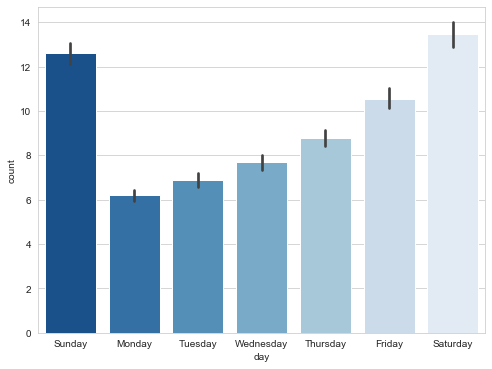

In [839]:
f, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.barplot(x='day',y='count',data=logins,order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],palette='Blues_r')

As seen above, it's least busy on Monday, and gets busier as the week progresses. It's busiest on weekends.

In [840]:
by_hour={}
for x in logins.reset_index().login_time:
    hour=x.hour
    by_hour[x]=hour

by_hour=pd.DataFrame.from_dict(by_hour,orient='index',columns=['hour'])
logins=logins.merge(by_hour,how='left',left_index=True,right_index=True)

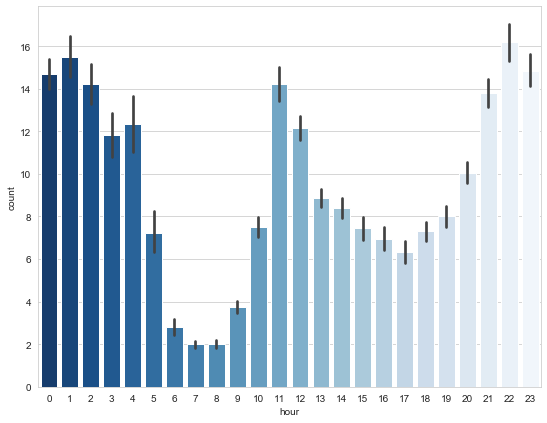

In [841]:
f, ax = plt.subplots(figsize=(9,7))
sns.set_style('whitegrid')
sns.barplot(x='hour',y='count',data=logins,palette='Blues_r')

We see that the peak times are around 1 am, 11 am, and 10 pm. It's least busy from 6 am-9 am.

Now, we want to see whether peak times differ on weekends and weekdays.

In [842]:
logins

,count,day,hour
login_time,,,
1970-01-01 20:00:00,2,Thursday,20
1970-01-01 20:15:00,6,Thursday,20
1970-01-01 20:30:00,9,Thursday,20
1970-01-01 20:45:00,7,Thursday,20
1970-01-01 21:00:00,1,Thursday,21
...,...,...,...
1970-04-13 17:45:00,5,Monday,17
1970-04-13 18:00:00,5,Monday,18
1970-04-13 18:15:00,2,Monday,18


In [843]:
week={}
for x in logins.day:
    if x in ['Saturday','Sunday']:
        week[x]='Weekend'
    else:
        week[x]='Weekday'
        
week=pd.DataFrame.from_dict(week,orient='index',columns=['weekend_weekday']).reset_index()
logins=logins.reset_index().merge(week,how='left',left_on='day',right_on='index')
logins=logins.drop('index',axis=1)

Text(0.5, 1.0, 'Peak Hours')

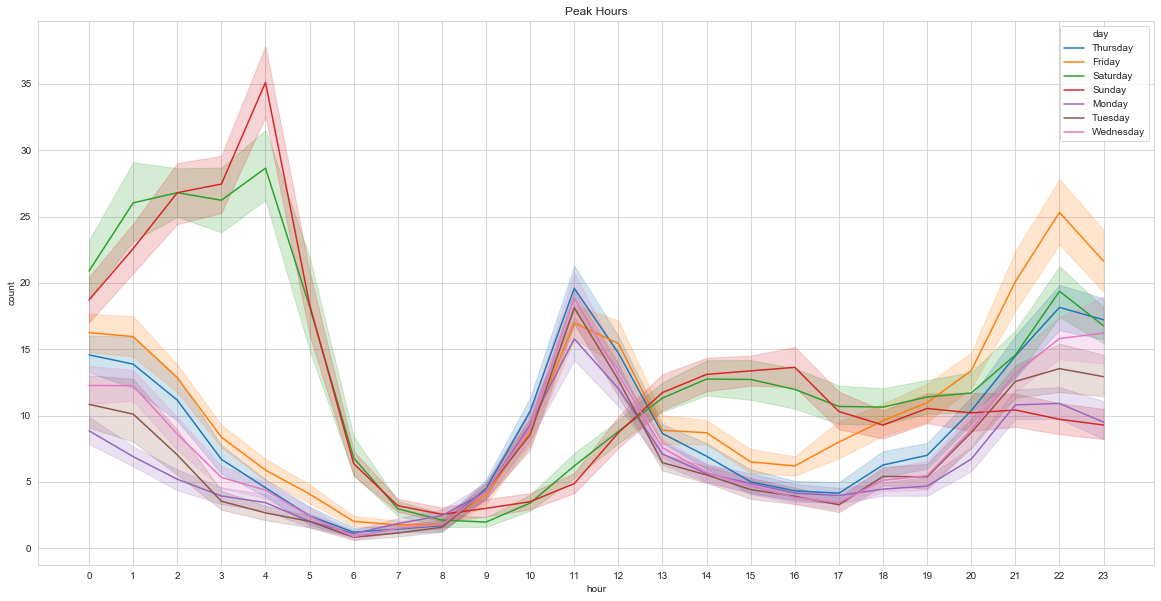

In [844]:
f, ax = plt.subplots(figsize=(20,10))
sns.set_style('whitegrid')
plt.xticks(np.arange(0,24))
sns.lineplot(x='hour',y='count',hue='day',data=logins)
plt.title('Peak Hours')

Text(0.5, 1.0, 'Peak Hours')

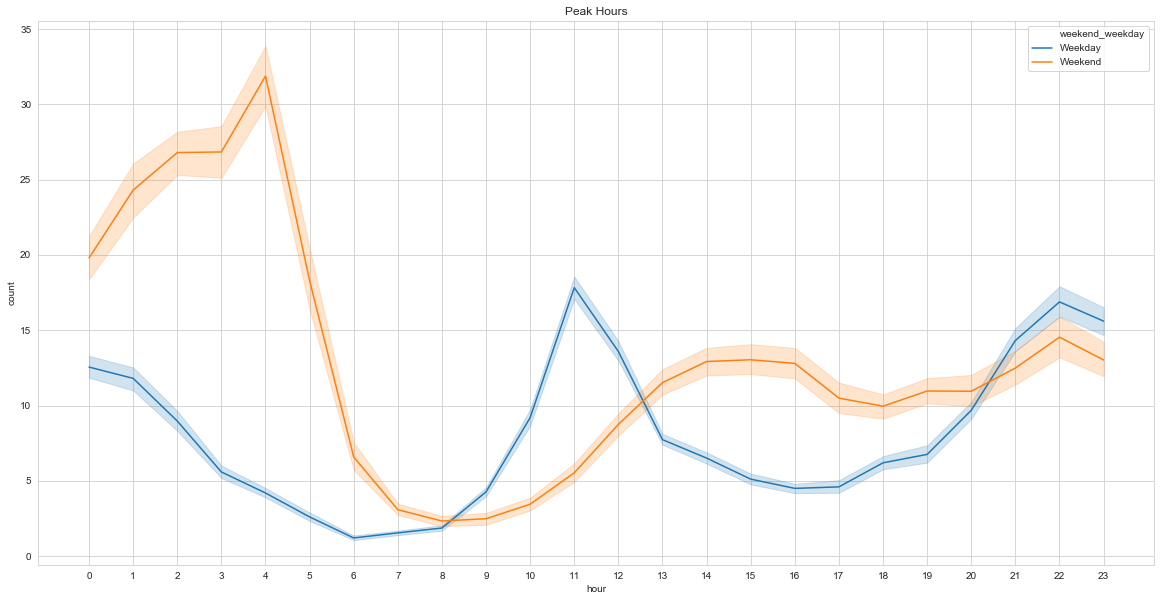

In [845]:
f, ax = plt.subplots(figsize=(20,10))
sns.set_style('whitegrid')
plt.xticks(np.arange(0,24))
sns.lineplot(x='hour',y='count',hue='weekend_weekday',data=logins)
plt.title('Peak Hours')

The lineplot shows that the peak times are highly dependent on whether it is on a weekday or a weekend. The peak time during weekdays are on **11 am and 10 pm**, while on weekends, it is on **4 am, 2-4 pm and 10 pm**.

In [846]:
f, ax = plt.subplots(figsize=(20,10))
sns.set_style('whitegrid')
week=logins.set_index('login_time').resample('W').sum()['count']
week.plot(kind='line')
plt.

SyntaxError: invalid syntax (<ipython-input-846-0fe6b077469e>, line 5)

Now we look at the overall trend of the login counts throughout the months that the data was recorded. After a slight decline from the first week of January to February, the login count was continuously increasing up until it reaches its peak which was in **mid March**. After this, the count slightly increased in the beginning of April, and then proceeded on declining. 

To conclude the first part of this analysis, through data visualization, we see that the demand is highly dependent on whether it's a weekday or a weekend, and the time of the day. Weekends and weekdays have different peak times. In general, there is higher demand on weekends. On weekdays, there is least demand on Mondays. We cannot generalize on what months are busiest because we only have data on four months.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure of success would be the change in activities (e.g. login counts/trips) in both cities. 

I choose this metric because right now, driving exclusively in one city means that demands on certain time of the days are not met (assuming there isn't currently a huge surplus in each city). For example, on weekdays during day time, Ultimate Metropolis's demand is the highest. But, if driver partners in Ultimate Gotham are not willing to cross the bridge and drive to the other city, supply is slow. This means: not everyone will match with a driver, or the price will be too high and prospective riders would not book the ride. If drivers start driving in both cities, number of trips should increase in total.

I would expect more trips during the day in Ultimate Metropolis and more trips in Ultimate Gotham at night. 

#### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
*a. how you will implement the experiment*

First, I would make sure to separate my data into two groups: before the proposed change and after. I will see the changes in trips made in each city after the reimbursement is implemented.

*b. what statistical test(s) you will conduct to verify the significance of the observation*



**Null Hypothesis: The number of trips made before and after the experiment are not statistically significant from each other**

**Alt Hypothesis: The number of trips made before and after the experiment ARE statistically significant from each other**


I would compare the average number of trips made by partner drivers after the toll reimbursement to the average number of trips in each city made before. I will perform a t-test to see if the change in this average is significant or not. Statisitical significance will be determined based on the p-value. I will see if it is significant at the 5% level.

*c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.*

If the number of trips in both cities increases at a significant level, I would call this experiment successful. This means that reimbursing partner drivers for toll fees did encourage them to go to the other cities, especially during times when one city was more active/busy than the other. 

All these suggestions I have proposed are mainly focused on seeing the effects of these reimbursements on encouraging drivers to drive in both cities. If we do want to see if this is profitable, we have to check the increase in profit caused by increase in overall activity vs the cost incurred due to the reimbursements. 

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
#### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

First, we add a binary column to indicate whether the user is active or not. This will be our target variable when building predictive models. 

In [ ]:
ultimate['active']=ultimate.trips_in_first_30_days>=1
ultimate.head()

In [ ]:
ultimate.info()

We see that there are null values on columns `avg_rating_of_driver`, `phone` and `avg_rating_by_driver`.

Columns `avg_rating_of_driver` and `avg_rating_by_driver` are numerical columns. The best way to deal with these null values is by filling it with the column's average.

In [ ]:
ultimate['avg_rating_of_driver']=(ultimate.avg_rating_of_driver.fillna(np.mean(ultimate.avg_rating_of_driver)))

In [ ]:
ultimate['avg_rating_by_driver']=(ultimate.avg_rating_by_driver.fillna(np.mean(ultimate.avg_rating_by_driver)))

The column `phone` is a categorical column that tells us what type of phone the user has. The two values are: "Iphone" and "Android". For null values in this column, we can put "Others". 

In [ ]:
ultimate['phone']=(ultimate.phone.fillna('Others'))

In [ ]:
#check if there are still null values

ultimate.info()

Now that we have dealt with all the null values, we will proceed to exploratory data analysis and data visualization

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.countplot(x="active",data=ultimate)

In [ ]:
print('Percentage of retained users: %.2f%%' %((sum(ultimate.active)/len(ultimate))*100))

Which cities have the most active users?

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.countplot(x="city",hue="active",data=ultimate)

What type of phone do active users usually use?

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.countplot(x="phone",hue="active",data=ultimate)

Most of the active users are iPhone users.

On average, what's the difference between the ` avg_rating_of_driver` of the active users and those who are not?

In [ ]:
x=ultimate.groupby('active').mean().reset_index()
x

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.barplot(x="active",y='avg_rating_of_driver',data=x)


On average, what's the difference between the ` avg_rating_by_driver` of the active users and those who are not?

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.barplot(x="active",y='avg_rating_by_driver',data=x)

As we can see above, there isn't much difference in the average ratings between active and non active users.

#### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.


Since we are now preidicting whether or not a user will be active in their 6 months on the system, we change create a new column and make it our new target variable.

In [ ]:
# convert to datetime objects

ultimate['signup_date']= pd.to_datetime(ultimate.signup_date)
ultimate['last_trip_date']= pd.to_datetime(ultimate.last_trip_date)

In [ ]:
ultimate['six_months_active']=ultimate['last_trip_date']>=(ultimate['signup_date']+pd.Timedelta(weeks=(6*4)))

In [ ]:
print('Percentage of retained users: %.2f%%' %((sum(ultimate.six_months_active)/len(ultimate))*100))

In [ ]:
#drop unneccessary columns

ultimate=ultimate.drop(['signup_date','last_trip_date'],axis=1)

In [ ]:
ultimate.head()


In [ ]:
cat_features = ['city','phone','ultimate_black_user','active']

for category in cat_features:
    ultimate[category]=ultimate[category].astype('category')

In [ ]:
#set column six_months_active as target variable

X=ultimate.drop('six_months_active',axis=1)
y=ultimate.six_months_active

In [ ]:
ultimate.info()

In [ ]:
#split data into training and test data

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


#pipeline for numeric features

num_features = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist',
                'avg_rating_by_driver']
num_transformer = [("scaler", StandardScaler())]
num_transformer = Pipeline(num_transformer)

#convert categorical variables into dummies

cat_features = ['city','phone','ultimate_black_user','active']
cat_transformer = [("encoder", OneHotEncoder())]
cat_transformer = Pipeline(cat_transformer)


preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features), 
                                               ("cat", cat_transformer, cat_features)])


Since this is a classification problem, we can train a Logistic Regression and a Random Forest model and see which performs best. We can then see how well it does on the test set by getting its F1 score. 

## Logistic Regression

In [ ]:
pipeline = Pipeline(steps=[("pre", preprocessor), ("lr", LogisticRegression(random_state = 42))])

params = {"lr__penalty" : ['l1', 'l2'], "lr__C" : np.logspace(0, 4, 10)}

#fitting the pipeline to the grid search

cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print("Training accuracy score from tuned Logistic Regression model:%.2f%%"%(cv.best_score_*100))

## Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier


pipeline = Pipeline(steps=[("pre", preprocessor), ("rf", RandomForestClassifier(random_state = 42))])

params = {"rf__n_estimators" : [75, 100, 150], "rf__max_depth" : [5, 10, 15]}


cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print("Training accuracy score from tuned Random Forest model:%.2f%%"%(cv.best_score_*100))

With the best parameters used, both models perform really well. Although, our RF model performs best. Next, we see how well it performs on a dataset it has not seen before, our test set.


In [ ]:
from sklearn import metrics

y_pred = cv.predict(X_test)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_f1 = metrics.f1_score(y_test, y_pred)


print("Model accuracy:%.2f%%"%(test_accuracy*100))
print("Model F1 score:%.2f%%"%(test_f1*100))

In [847]:
metrics.recall_score(y_test,y_pred)

0.0

In [848]:
metrics.f1_score(y_test,y_pred)

/Users/anna/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [849]:
metrics.precision_score(y_test,y_pred)

/Users/anna/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [851]:
metrics.confusion_matrix(y_test,y_pred)

array([[13982,     0],
       [ 1018,     0]])

Our model does slightly better with our test set than our train set.

In [804]:
#using our random forest model, we can extract the feature importances


pipeline.fit(X_train,y_train)

features=pipeline.named_steps['rf'].feature_importances_

In [826]:
categorical_cols = list(pd.get_dummies(ultimate[cat_features]).columns)
feature_importances = pd.DataFrame({'feature': list(num_features + categorical_cols), 'importance': features})

In [830]:
feature_importances.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.296456
4,weekday_pct,0.166807
3,surge_pct,0.105872
1,avg_rating_of_driver,0.103195
6,avg_rating_by_driver,0.085509
2,avg_surge,0.082557
0,trips_in_first_30_days,0.082145
8,city_King's Landing,0.011771
9,city_Winterfell,0.011677
7,city_Astapor,0.009248


`avg_dist` seems to be key indicator of model performance. This is the average distance per trip taken in the first 30 days after signup. This could signify the neccessity of the app to the user. Those who need to travel greater distances often end up being active users, compared to those who don't need it as often.

The 2nd and 3rd most important features can also signify the necessity of this app/service since higher values in these columns mean that they often use it on weekdays (most probably for work/school) and surge prices don't deter them.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

The top key features shows that you are more likely to use it if you need to travel longer distances (avg_dist), use it regularly on weekdays (weekday_pct) and need it enough that surge pricing does not affect your decision (surge_pct). To increase retention rates, I suggest that the company also create incentives for people who may not need as much to keep on using it. This includes making it cheaper on the weekends (since most active users have bigger weekday_pct), and increasing supply to avoid surge pricing (so that they are not deterred in using).
